# GradientBoostingRegressor(GBDT)

In [1]:
import os
import sys
current_path = os.getcwd()
current_path

'/workspaces/Band-gap-predict/Models/GBDT'

In [2]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../../'))

In [3]:
# Importing the custom module
from Utools.draw import model_performance

In [4]:
import pandas as pd
import numpy as np
np.random.seed(42)

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
# save the model 
import joblib

In [5]:
# some global variables
RANDOM_SEED = 42

In [6]:
# Load data
file_dir = os.path.join(current_path, '../../Data/composition_data/feature_data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'dft', 'train.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'dft', 'test.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'exp', 'train.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'exp', 'test.csv'))

In [7]:
dft_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46514 entries, 0 to 46513
Columns: 108 entries, composition to band_gap
dtypes: float64(107), object(1)
memory usage: 38.3+ MB


In [8]:
dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp__train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp__train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

In [9]:
def model_train(model, X_train, y_train):
    """
    Train and evaluate a Random Forest Regressor.
    """
    # using pipline to scale the data and fit the model
    pipe = Pipeline([
        ('scaler', StandardScaler()), # StandardScaler's mean is 0 and std is 1, Z-score normalization
        ('model', model)
    ], verbose=True)

    # Fit the model
    pipe.fit(X_train, y_train)
    return pipe

def predict(model, X_test):
    # Predict on the test set
    y_pred = model.predict(X_test)
    return y_pred

In [10]:
# Predict on the test set
def results(model, X_test, y_test, save_df, train_type='dft', test_type='dft'):
    """
    Predict and evaluate the model on the test set.
    Save the results(model, figures, predictions)
    """
    type = f'{train_type}_train_{test_type}_test'
    y_pred = predict(model, X_test)

    # save the results
    # save fig
    fig_path = os.path.join(current_path, 'figures')
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    fig_path = os.path.join(fig_path, f'{type}.png')
    r2, rmse, mae = model_performance(y_test, y_pred, fig_path)
    print(f"{type} results:")
    print(f"R^2: {r2:.4f}", f"RMSE: {rmse:.4f}", f"MAE: {mae:.4f}")

    # save the model
    # save the pipeline model(contains scaler and model)
    model_path = os.path.join(current_path, 'model')
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model_path = os.path.join(model_path, f'{train_type}.pkl')
    joblib.dump(model, model_path)
    # save y_pred
    file_path = os.path.join(current_path, 'predictions')
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    file_path = os.path.join(file_path, f'{type}.csv')
    y_pred_df = save_df.copy()
    y_pred_df['predicted_band_gap'] = y_pred
    y_pred_df.to_csv(file_path, index=False)

    return [r2, rmse, mae]

## Model -- Gradient Boosting Decision Tree

In [11]:
gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_features='sqrt',
    random_state=RANDOM_SEED
)

## DFT Train

In [12]:
# dft train
dft_model = model_train(gbr_model, dft_train_X, dft_train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s


[Pipeline] ............. (step 2 of 2) Processing model, total=  28.9s


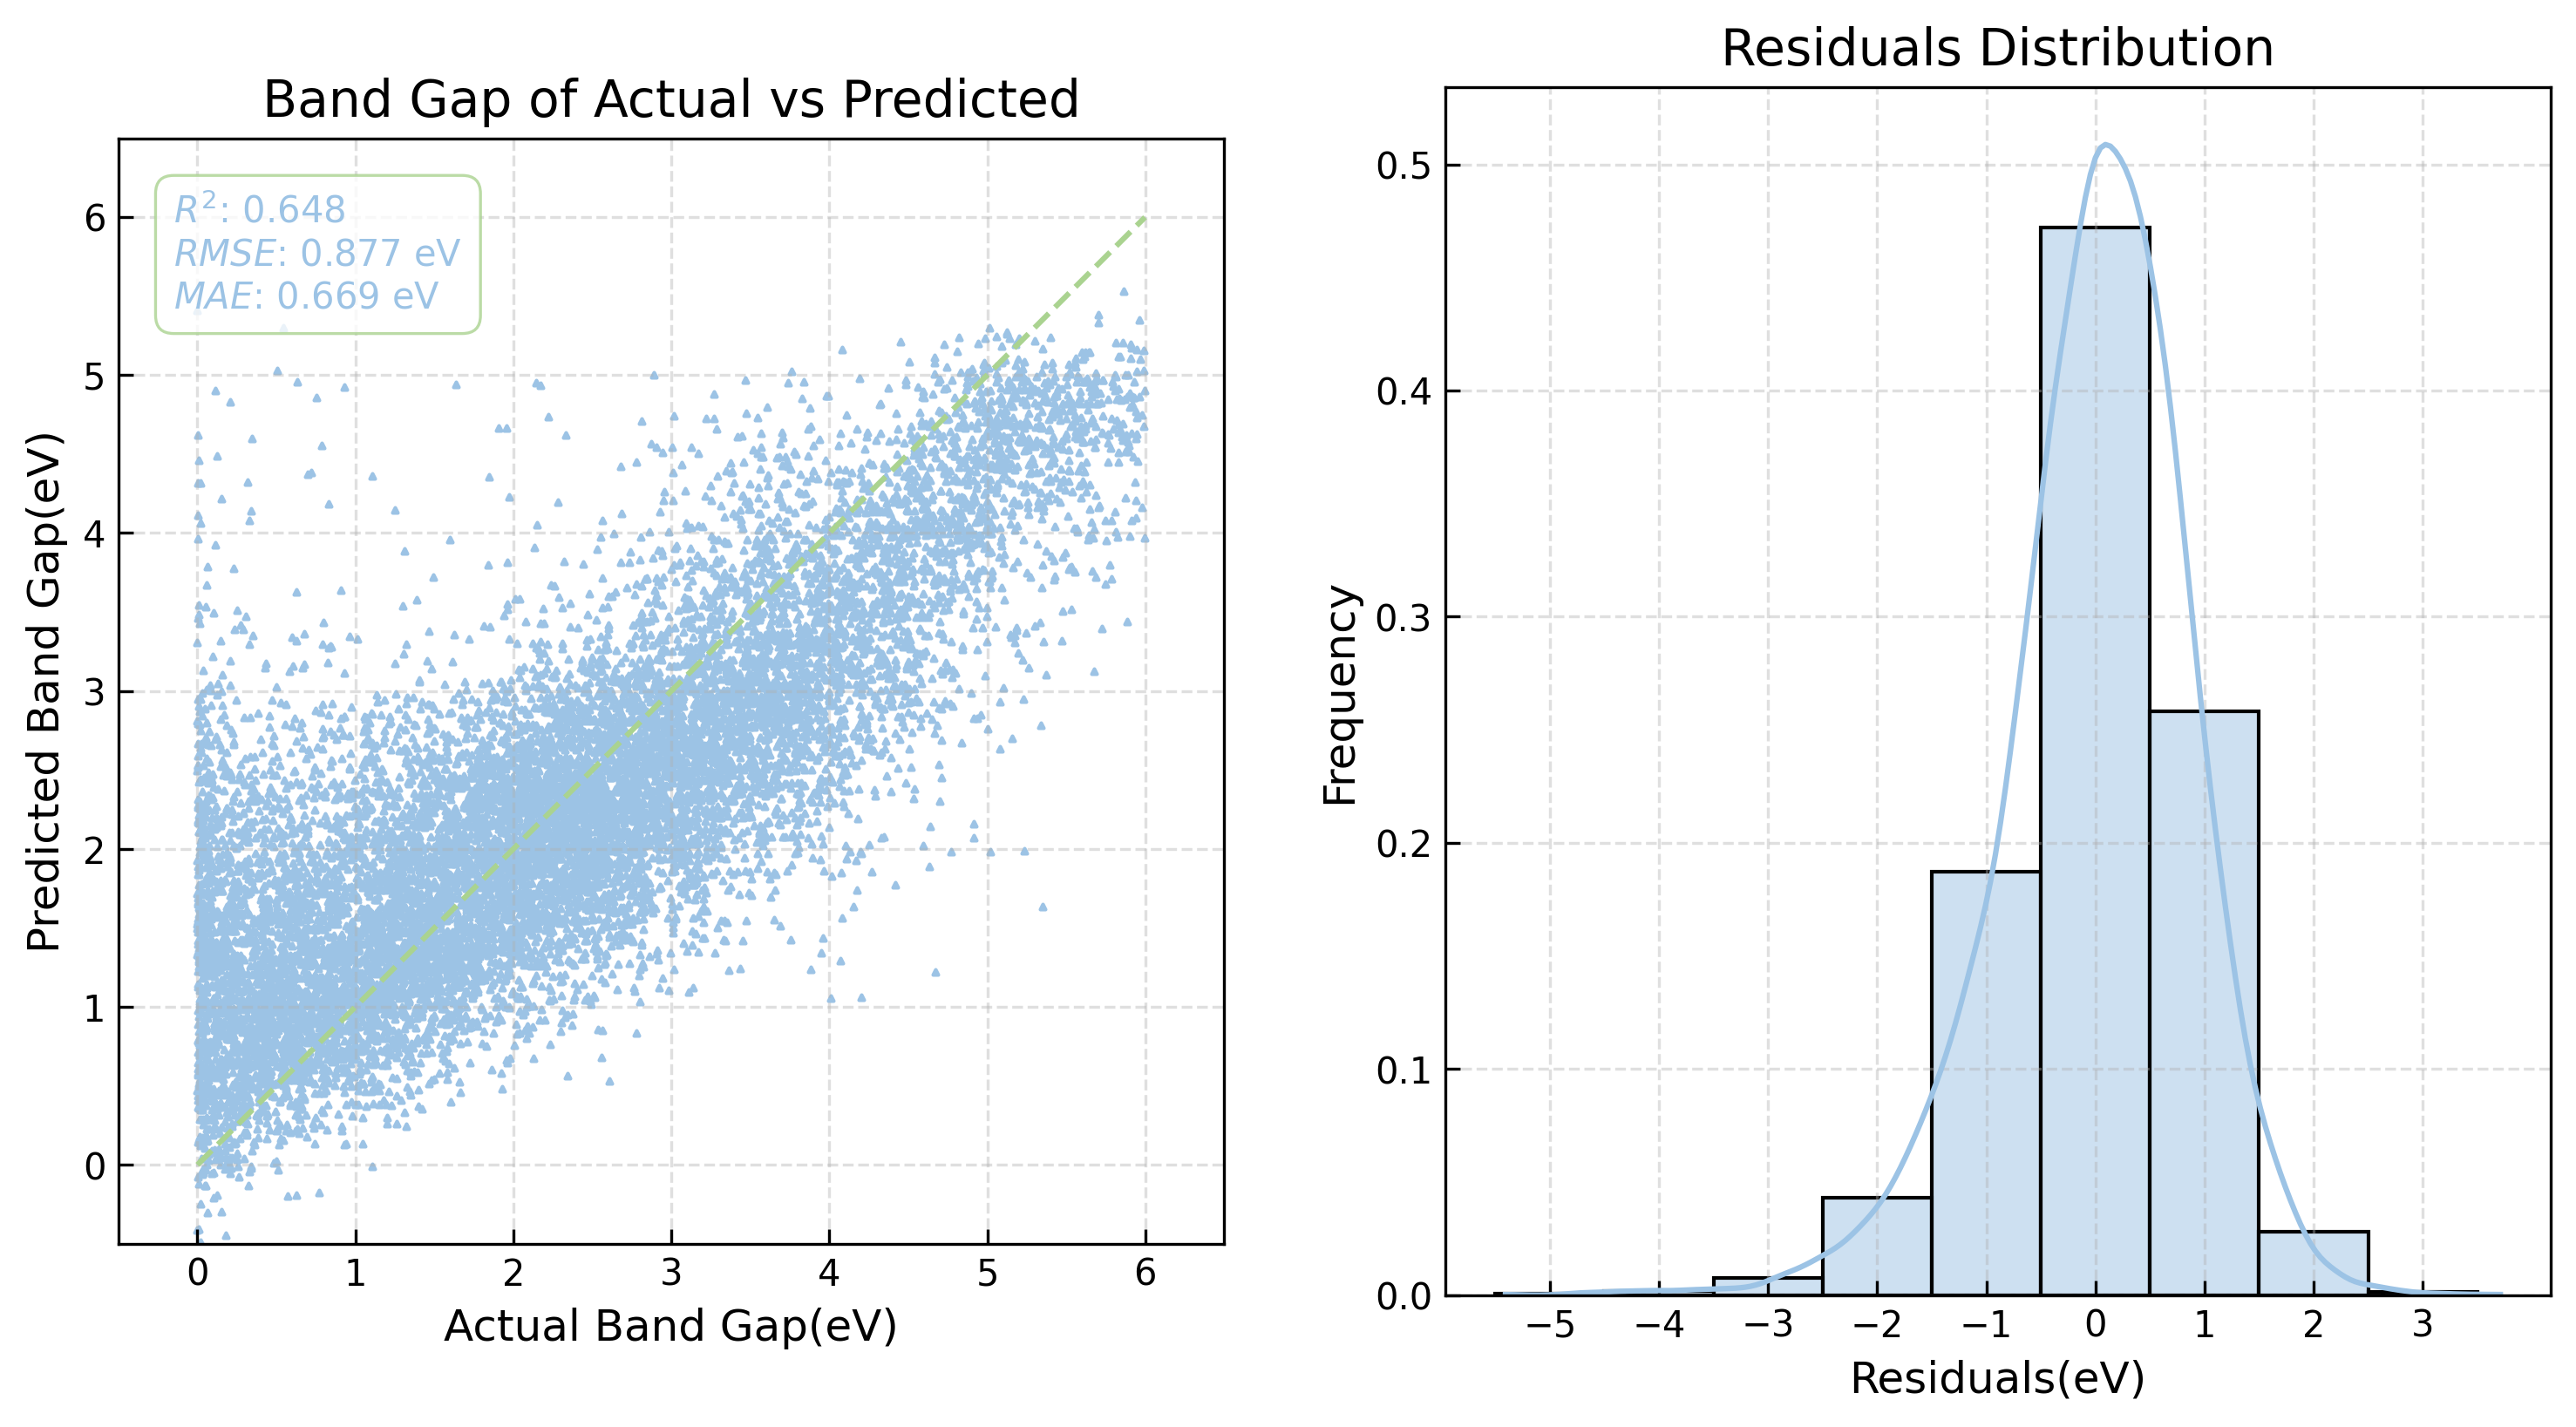

dft_train_dft_test results:
R^2: 0.6480 RMSE: 0.8770 MAE: 0.6692


In [13]:
results_df = pd.DataFrame(columns=['Train', 'Test', 'R^2', 'RMSE', 'MAE'])
# dft test
res1 = results(dft_model, dft_test_X, dft_test_y, dft_test, train_type='dft', test_type='dft')
results_df.loc[len(results_df)] = ['dft', 'dft'] + res1

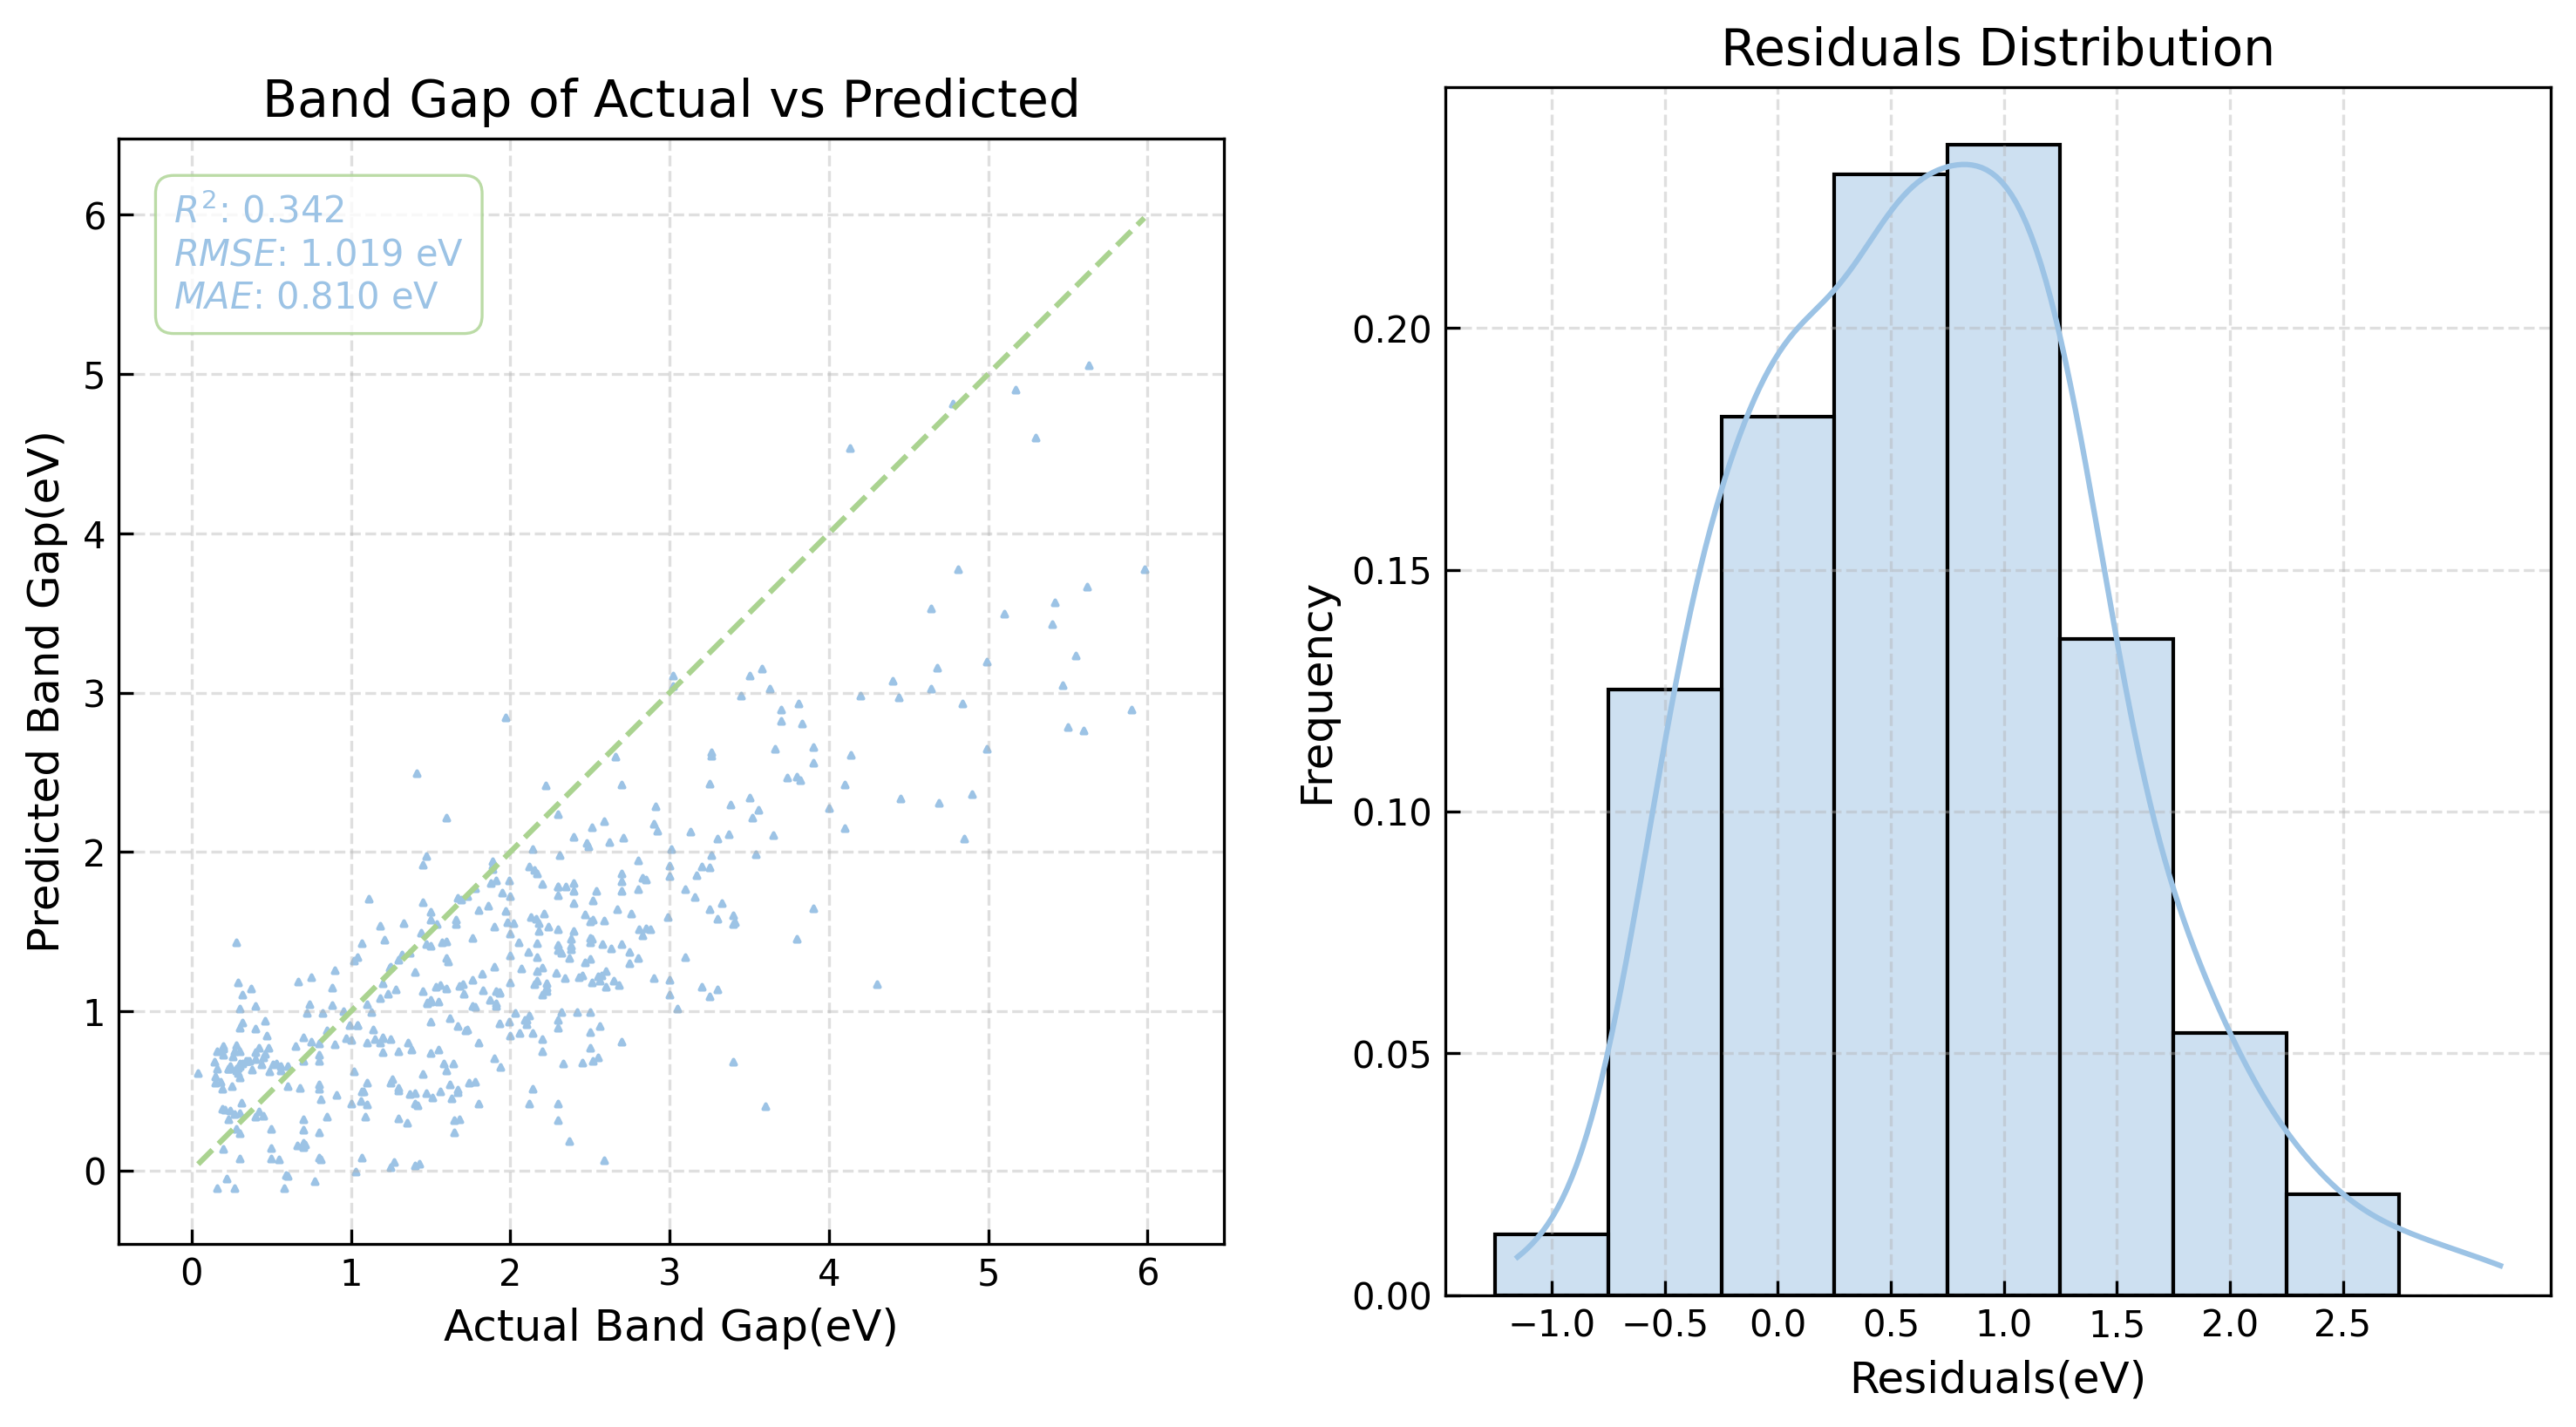

dft_train_exp_test results:
R^2: 0.3422 RMSE: 1.0192 MAE: 0.8098


In [14]:
# Predict on the experimental data
res2 = results(dft_model, exp_test_X, exp_test_y, exp_test, train_type='dft', test_type='exp')
results_df.loc[len(results_df)] = ['dft', 'exp'] + res2

## Experimental train

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s


[Pipeline] ............. (step 2 of 2) Processing model, total=   1.4s


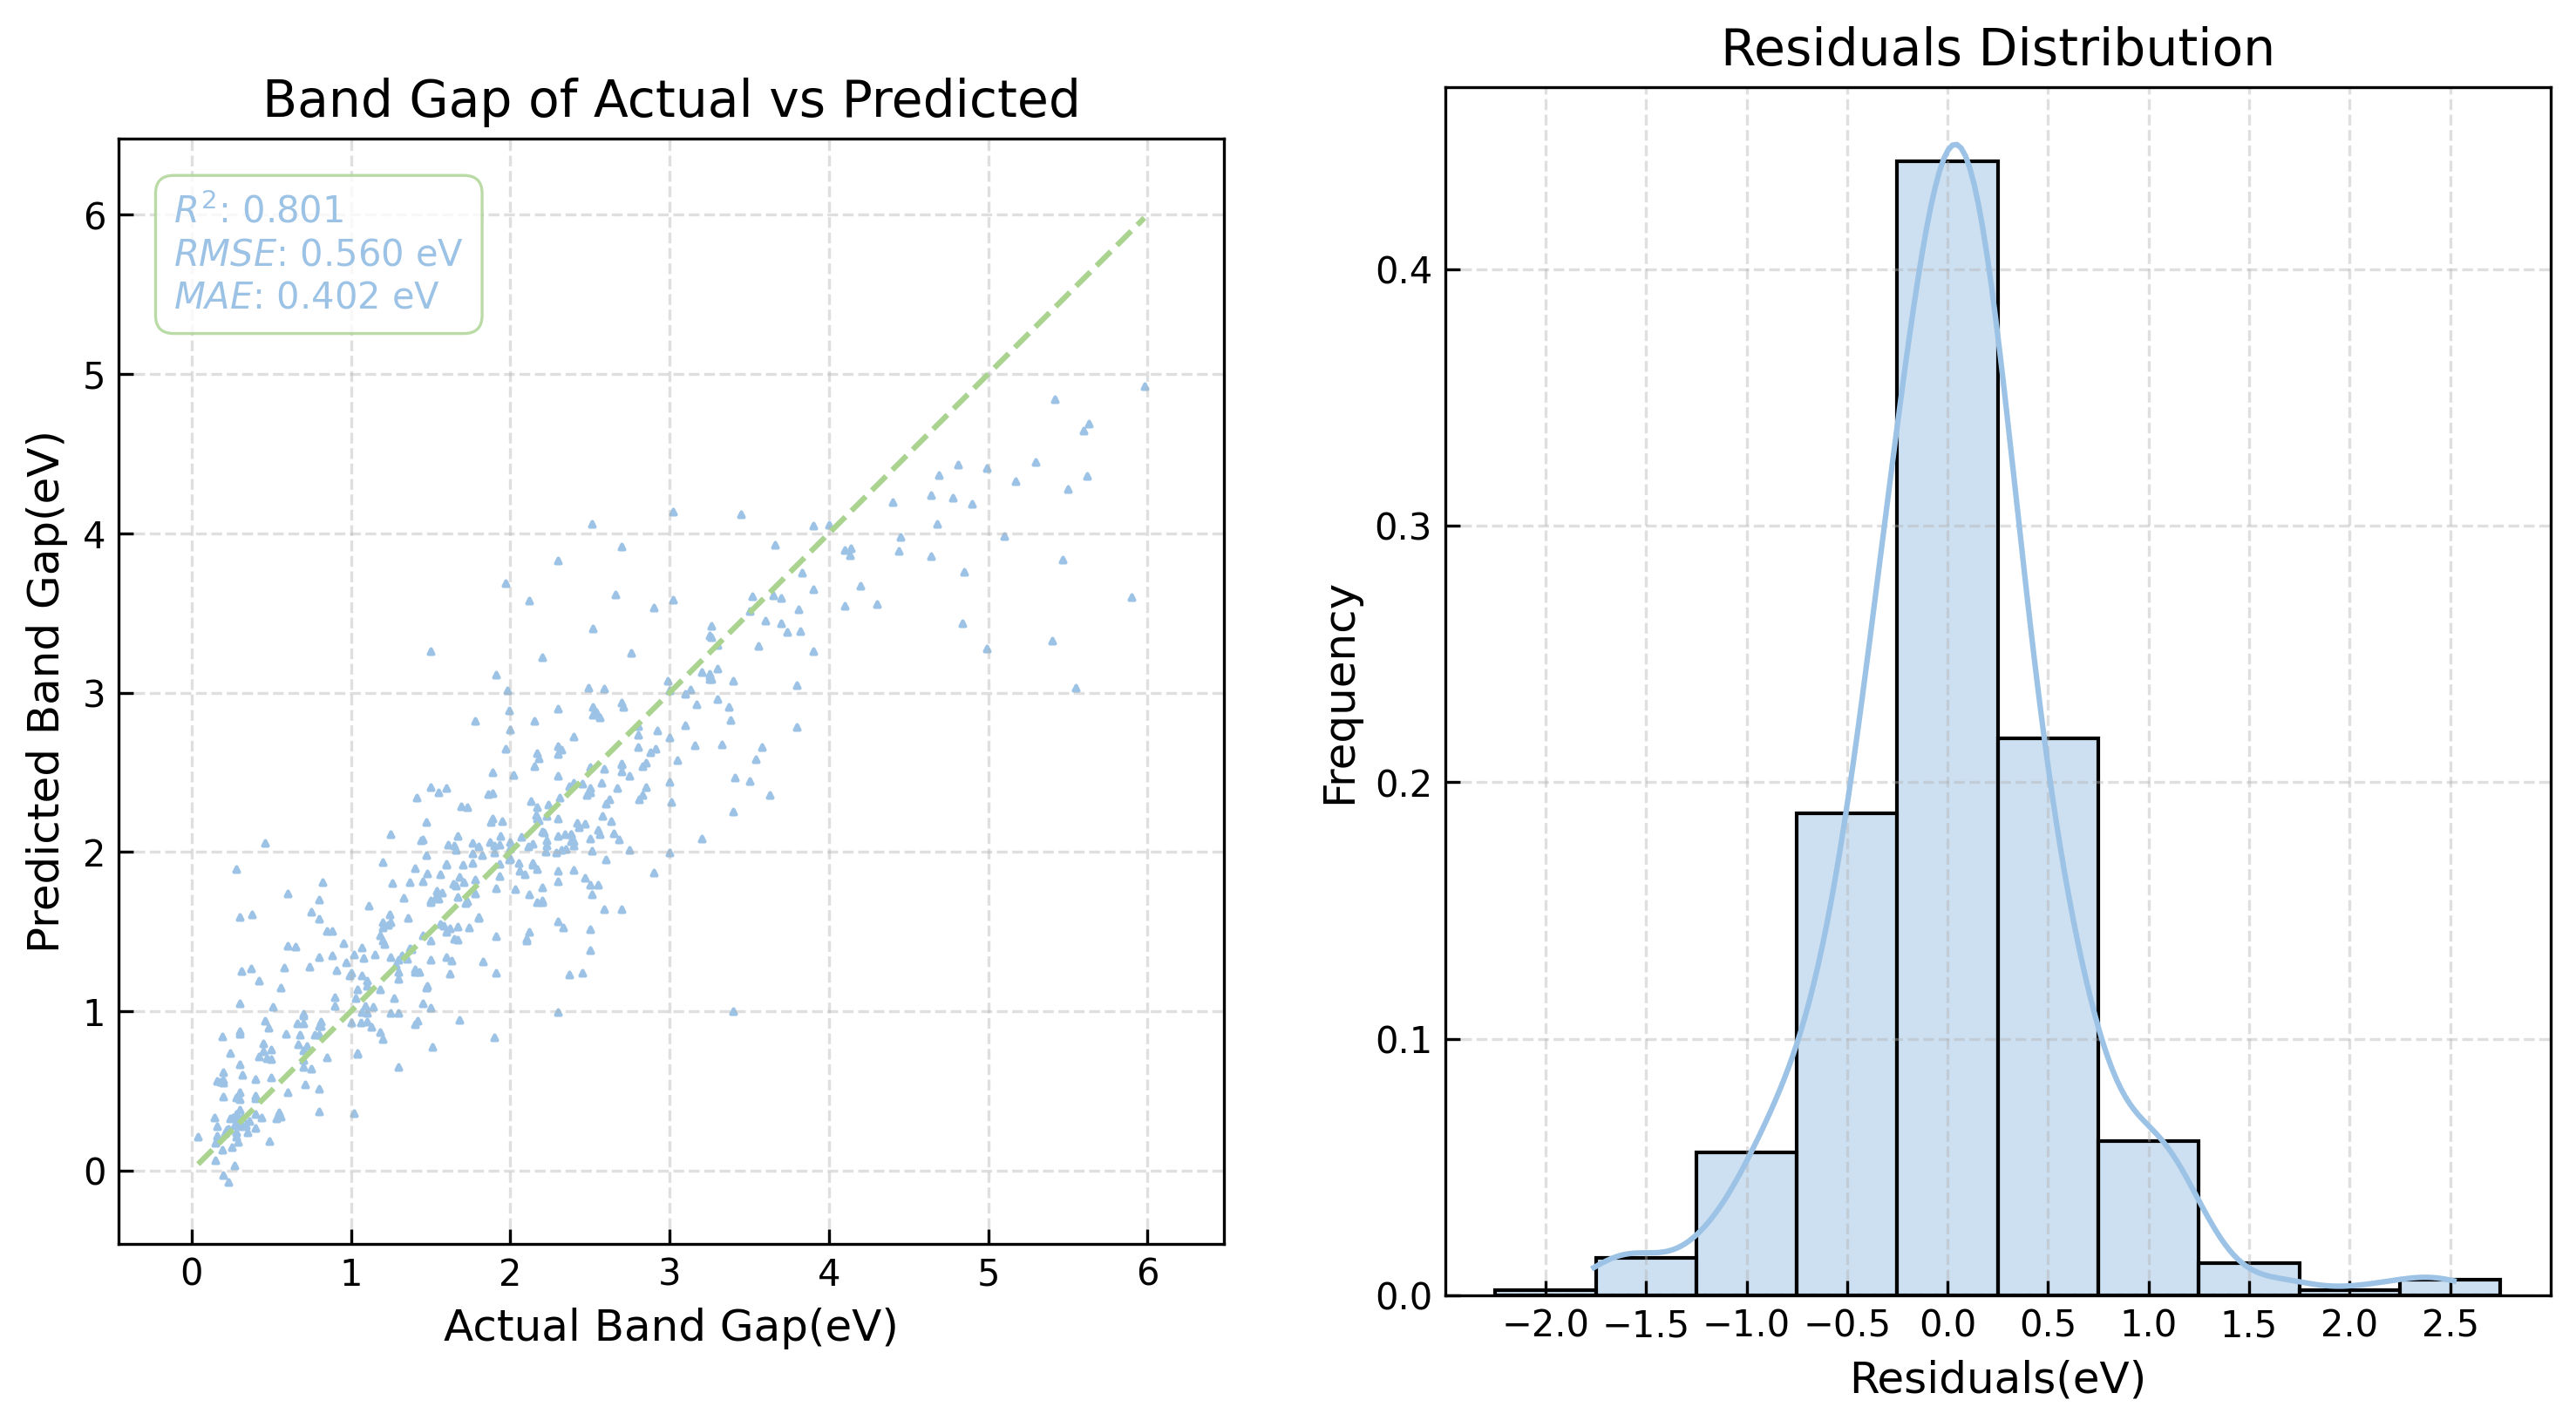

exp_train_exp_test results:
R^2: 0.8011 RMSE: 0.5604 MAE: 0.4020


In [15]:
# Train and evaluate the model on the experimental data
exp_model = model_train(gbr_model, exp__train_X, exp__train_y)
# Predict on the test set
res3 = results(exp_model, exp_test_X, exp_test_y, exp_test, train_type='exp', test_type='exp')
results_df.loc[len(results_df)] = ['exp', 'exp'] + res3

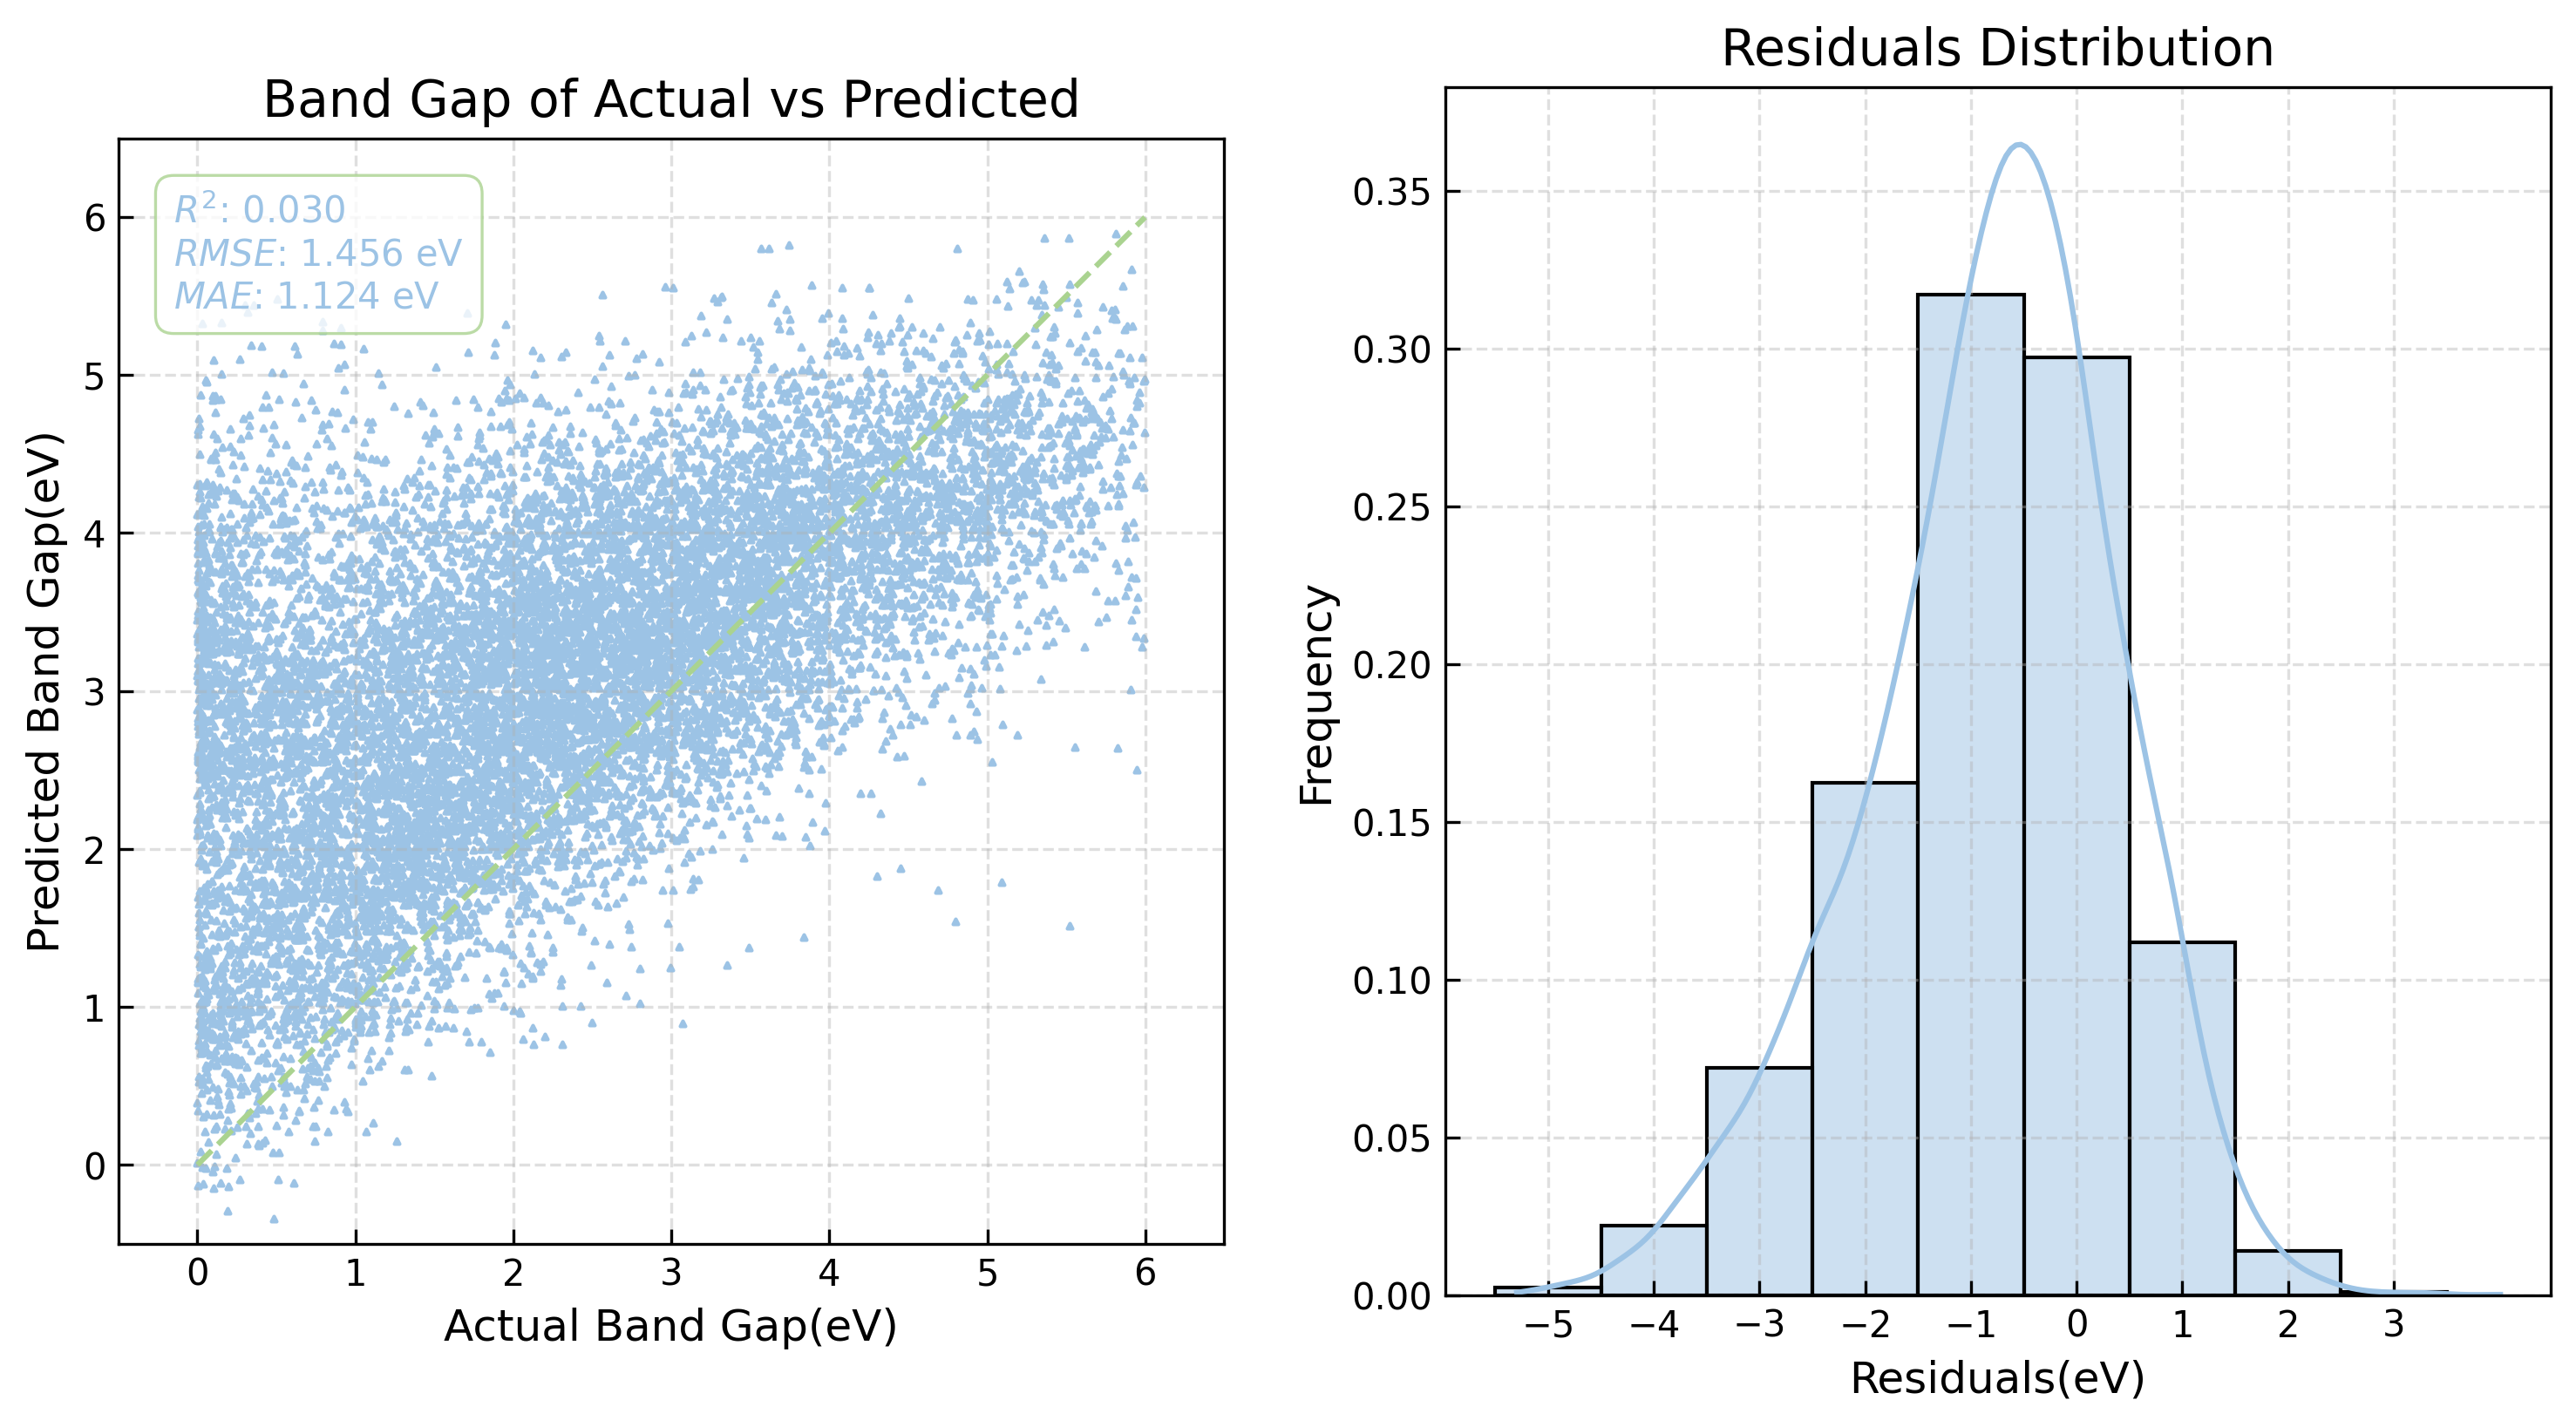

exp_train_dft_test results:
R^2: 0.0302 RMSE: 1.4557 MAE: 1.1239


In [16]:
# Predict on the dft data
res4 = results(exp_model, dft_test_X, dft_test_y, dft_test, train_type='exp', test_type='dft')
results_df.loc[len(results_df)] = ['exp', 'dft'] + res4

In [17]:
results_df

,Train,Test,R^2,RMSE,MAE
0,dft,dft,0.647965,0.877012,0.669172
1,dft,exp,0.342210,1.019222,0.809767
2,exp,exp,0.801139,0.560401,0.401988
3,exp,dft,0.030162,1.455667,1.123900


In [18]:
# save the results
file_path = os.path.join(current_path, 'model_performance.csv')
results_df.to_csv(file_path, index=False)